In [ ]:
from class_sample_testing import *

1. Load Spectral Reflectances Cubes


In [ ]:
# Train samples
train = sample_testing(test=False, trial=2, operator=3)
result1 = train.test_sample()

Reference circle detection...


C:\Users\julia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\julia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 255, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [ ]:
# Run the Train samples and all the test samples
train = sample_testing(test=False)
result1 = train.test_sample()

test11 = sample_testing(test=True, trial=1, operator=1)
result2 = test11.test_sample()

test12 = sample_testing(test=True, trial=1, operator=2)
result3 = test12.test_sample()

test13 = sample_testing(test=True, trial=1, operator=3)
result4 = test13.test_sample()

test21 = sample_testing(test=True, trial=2, operator=1)
result5 = test21.test_sample()

test22 = sample_testing(test=True, trial=2, operator=2)
result6 = test22.test_sample()

test23 = sample_testing(test=True, trial=2, operator=3)
result7 = test23.test_sample()

In [ ]:
# Save results to excel file
dfs = [
    result1,
    result2,
    result3,
    result4,
    result5,
    result6,
    result7,
]  
combined = pd.concat(dfs, ignore_index=True)
combined.to_excel("results.xlsx", index=False)

In [ ]:
# Comparative plot of test CTQs
samples_including_s0 = test21.sample_folders
new_row = {
    "ID": "s0",
    "DE_mean": np.nan,
    "D_radius": np.nan,
    "CTQ1": np.nan,
    "CTQ2": np.nan,
    "Defect?": np.nan,
}
# Add mock rows if necessary
for result_name in ["result2", "result3", "result4", "result5", "result6", "result7"]:
    result_df = locals()[result_name]
    if "s0" not in result_df["ID"].values:
        locals()[result_name] = pd.concat(
            [pd.DataFrame([new_row]), result_df], ignore_index=True
        )


def sort_by_defect_id(df):
    df["defect_num"] = df["ID"].str.extract(r"s(\d+)")[0]
    df["defect_num"] = pd.to_numeric(df["defect_num"], errors="coerce").astype("Int64")
    df = df.sort_values("defect_num").reset_index(drop=True)
    return df.drop(columns=["defect_num"])


tests = [result2, result3, result4, result5, result6, result7]
#tests = [sort_by_defect_id(t) for t in tests]

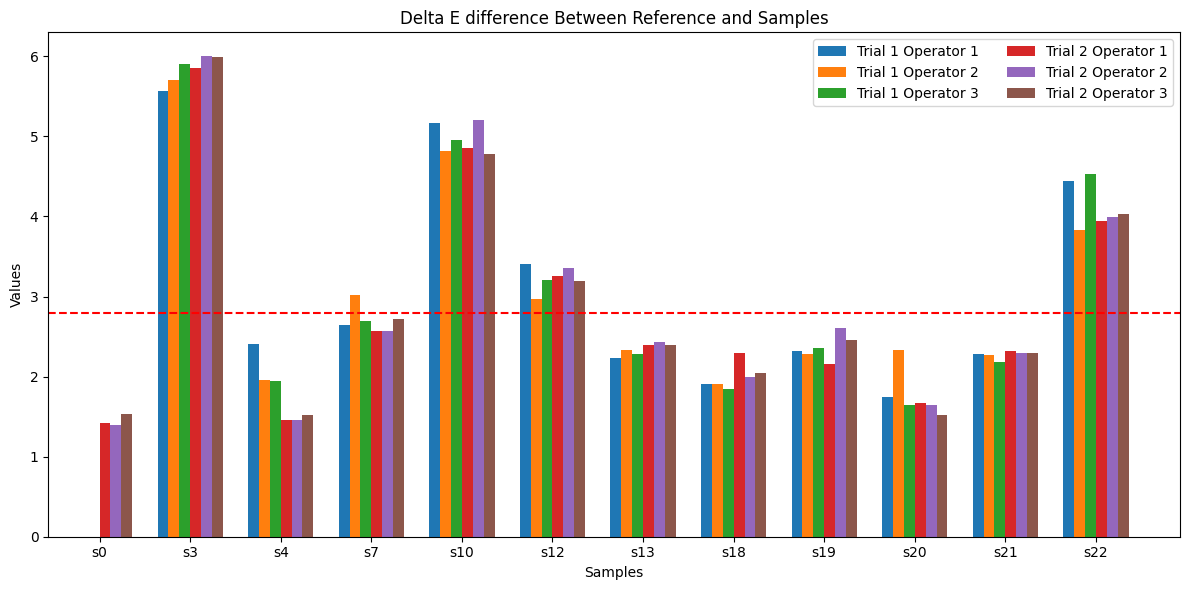

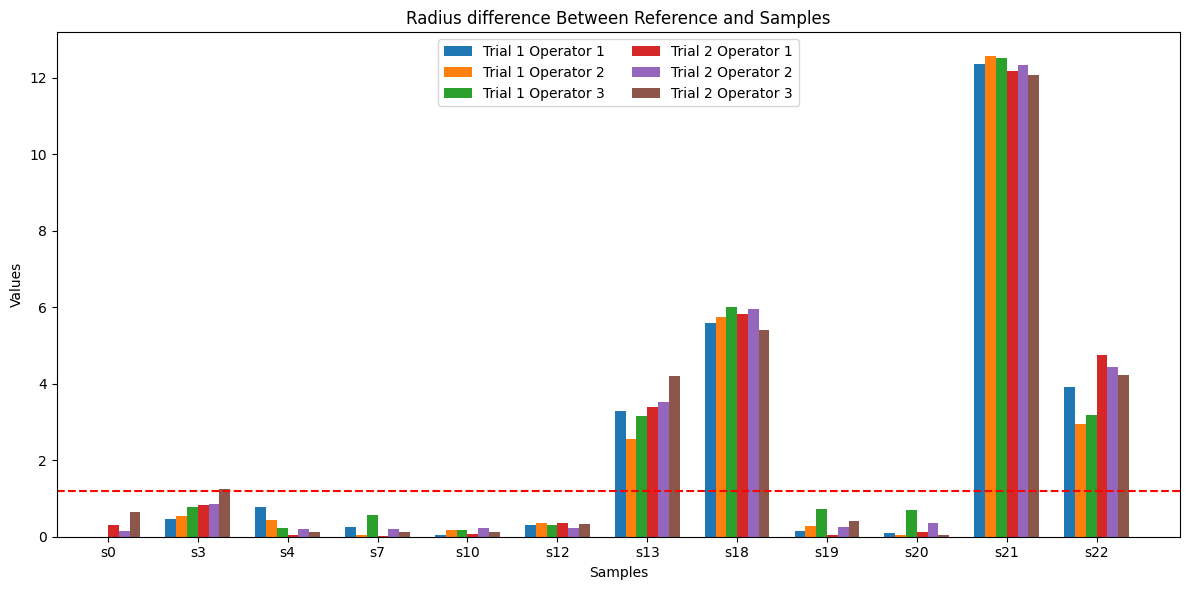

In [6]:
all_deltae = [t["DE_mean"].values for t in tests]
all_radius = [t["D_radius"].values for t in tests]

variances1 = np.nanvar(all_deltae, axis=0)
variances2 = np.nanvar(all_radius, axis=0)

def plot_ctq_values(values, title, threshold, sample_labels):
    x = np.arange(len(values[0]))
    width = 0.12

    plt.figure(figsize=(12, 6))
    plt.bar(x - 2.5 * width, values[0], width, label="Trial 1 Operator 1")
    plt.bar(x - 1.5 * width, values[1], width, label="Trial 1 Operator 2")
    plt.bar(x - 0.5 * width, values[2], width, label="Trial 1 Operator 3")
    plt.bar(x + 0.5 * width, values[3], width, label="Trial 2 Operator 1")
    plt.bar(x + 1.5 * width, values[4], width, label="Trial 2 Operator 2")
    plt.bar(x + 2.5 * width, values[5], width, label="Trial 2 Operator 3")
    plt.axhline(y=threshold, color="red", linestyle="--", linewidth=1.5)
    plt.xticks(x, sample_labels)
    plt.xlabel("Samples")
    plt.ylabel("Values")
    plt.title(title)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()


plot_ctq_values(
    all_deltae,
    "Delta E difference Between Reference and Samples",
    2.8,
    samples_including_s0,
)
plot_ctq_values(
    all_radius,
    "Radius difference Between Reference and Samples",
    1.2,
    samples_including_s0,
)

# Results from meeting 6


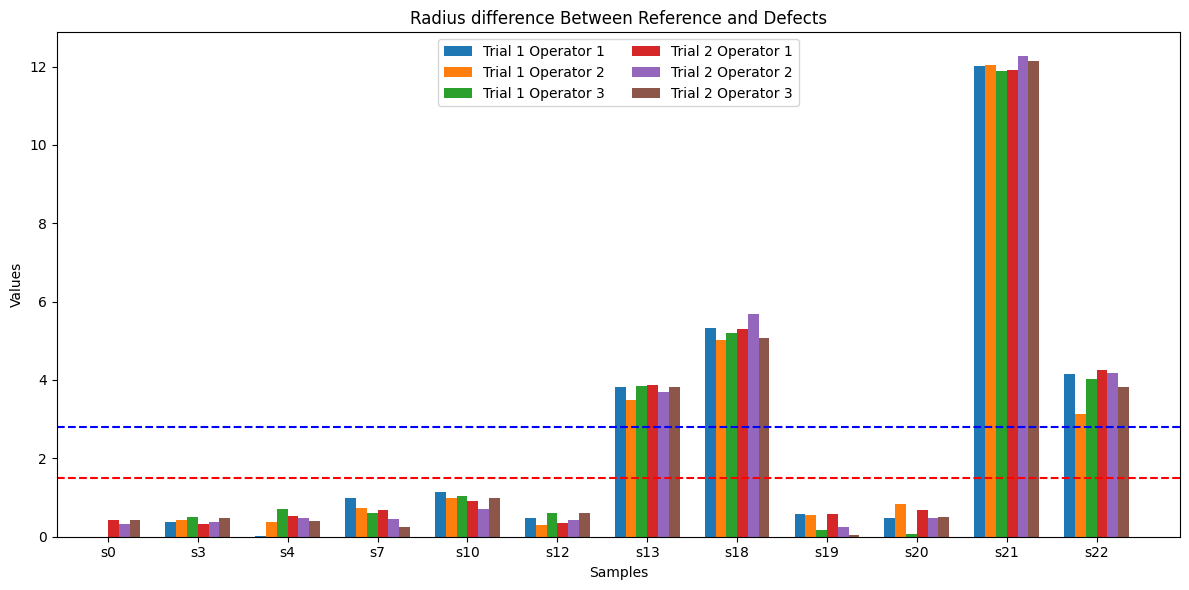

In [7]:
values1 = [np.nan, 0.37, 0.02, 1.00, 1.14, 0.47, 3.81, 5.33, 0.57, 0.48, 12.02, 4.15]
values2 = [np.nan, 0.43, 0.38, 0.73, 0.98, 0.29, 3.49, 5.01, 0.55, 0.84, 12.05, 3.14]
values3 = [np.nan, 0.50, 0.70, 0.60, 1.04, 0.61, 3.84, 5.19, 0.18, 0.06, 11.89, 4.02]
values4 = [0.43, 0.32, 0.52, 0.68, 0.91, 0.35, 3.87, 5.29, 0.59, 0.69, 11.90, 4.26]
values5 = [0.33, 0.38, 0.49, 0.45, 0.71, 0.42, 3.69, 5.69, 0.24, 0.49, 12.26, 4.19]
values6 = [0.42, 0.47, 0.39, 0.24, 1.00, 0.60, 3.83, 5.07, 0.05, 0.50, 12.13, 3.83]

# Stack data for plotting
all_values = np.array(
    [result2["D_radius"], values2, values3, values4, values5, values6]
)

# Plot setup
x = np.arange(len(samples_including_s0))
width = 0.12

plt.figure(figsize=(12, 6))
plt.bar(x - 2.5 * width, values1, width, label="Trial 1 Operator 1")
plt.bar(x - 1.5 * width, values2, width, label="Trial 1 Operator 2")
plt.bar(x - 0.5 * width, values3, width, label="Trial 1 Operator 3")
plt.bar(x + 0.5 * width, values4, width, label="Trial 2 Operator 1")
plt.bar(x + 1.5 * width, values5, width, label="Trial 2 Operator 2")
plt.bar(x + 2.5 * width, values6, width, label="Trial 2 Operator 3")
plt.axhline(y=1.5, color="red", linestyle="--", linewidth=1.5)
plt.axhline(y=2.8, color="blue", linestyle="--", linewidth=1.5)

plt.xticks(x, samples_including_s0)
plt.xlabel("Samples")
plt.ylabel("Values")
plt.title("Radius difference Between Reference and Defects")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

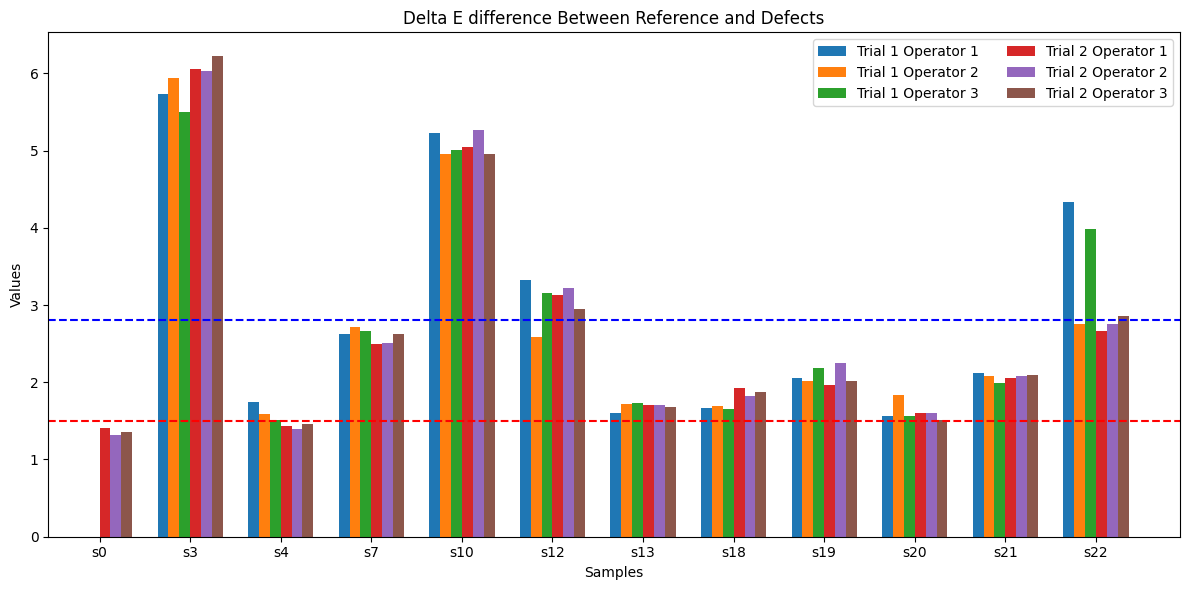

In [8]:
# Values from presentatioon of meeting 6
# Define all 6 lists
values1 = [np.nan, 5.73, 1.75, 2.62, 5.23, 3.32, 1.60, 1.67, 2.06, 1.56, 2.12, 4.33]
values2 = [np.nan, 5.94, 1.59, 2.71, 4.96, 2.59, 1.72, 1.69, 2.01, 1.84, 2.08, 2.76]
values3 = [np.nan, 5.50, 1.51, 2.66, 5.01, 3.16, 1.73, 1.65, 2.18, 1.56, 1.99, 3.98]

values4 = [1.41, 6.06, 1.44, 2.50, 5.04, 3.13, 1.70, 1.92, 1.96, 1.60, 2.06, 2.66]
values5 = [1.32, 6.03, 1.39, 2.51, 5.27, 3.22, 1.70, 1.82, 2.25, 1.60, 2.08, 2.76]
values6 = [1.36, 6.22, 1.46, 2.63, 4.95, 2.95, 1.68, 1.88, 2.01, 1.51, 2.10, 2.86]


# Define sample names (including d0)

# Stack data for plotting
all_values = np.array(
    [result2["D_radius"], values2, values3, values4, values5, values6]
)

# Plot setup
x = np.arange(len(samples_including_s0))
width = 0.12

plt.figure(figsize=(12, 6))
plt.bar(x - 2.5 * width, values1, width, label="Trial 1 Operator 1")
plt.bar(x - 1.5 * width, values2, width, label="Trial 1 Operator 2")
plt.bar(x - 0.5 * width, values3, width, label="Trial 1 Operator 3")
plt.bar(x + 0.5 * width, values4, width, label="Trial 2 Operator 1")
plt.bar(x + 1.5 * width, values5, width, label="Trial 2 Operator 2")
plt.bar(x + 2.5 * width, values6, width, label="Trial 2 Operator 3")
plt.axhline(y=1.5, color="red", linestyle="--", linewidth=1.5)
plt.axhline(y=2.8, color="blue", linestyle="--", linewidth=1.5)

plt.xticks(x, samples_including_s0)
plt.xlabel("Samples")
plt.ylabel("Values")
plt.title("Delta E difference Between Reference and Defects")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

## STD


In [ ]:
# def std_reflectance_in_circle(hypercube, center, radius, transform=None):
#     bands, h, w = hypercube.shape

#     hypercube_aligned = np.stack(
#         [cv2.warpAffine(hypercube[i], transform, (w, h)) for i in range(bands)]
#     )

#     mask = np.zeros((h, w), dtype=np.uint8)
#     cx, cy = int(round(center[0])), int(round(center[1]))
#     r = int(radius) - 5
#     cv2.circle(mask, (cx, cy), r, 1, -1)

#     std_reflectance = []
#     for i in range(bands):
#         band = hypercube_aligned[i]
#         masked_pixels = band[mask == 1]
#         if masked_pixels.size > 0:
#             std_reflectance.append(np.std(masked_pixels))
#         else:
#             std_reflectance.append(np.nan)

#     return np.array(std_reflectance)


# new_spectra = {}
# new_spectra_std = {}

# for defect_name, transform in zip(samples_including_s0, defect_homographies):
#     cube = defect_cubes[defect_name]
#     new_spectra[defect_name] = average_reflectance_in_circle(
#         cube, circle_center, circle_radius, transform=transform
#     )
#     new_spectra_std[defect_name] = std_reflectance_in_circle(
#         cube, circle_center, circle_radius, transform=transform
#     )


# for defect_name in samples_including_s0:
#     std_values = new_spectra_std[defect_name]
#     mean_values = new_spectra[defect_name]

#     print(
#         f"{defect_name}: Mean Std across wavelengths = {np.nanmean(std_values):.6f}, Coefficient of Variation (mean) = {np.nanmean(std_values/mean_values)*100:.2f}%"
#     )

In [ ]:
# avg_std_per_defect = {
#     name: np.nanmean(std_values) for name, std_values in new_spectra_std.items()
# }

# sorted_defects = sorted(avg_std_per_defect.items(), key=lambda x: x[1], reverse=True)
# for rank, (name, std_val) in enumerate(sorted_defects, 1):
#     print(f"{name}: {std_val:.6f}")